In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import unicodedata
from pathlib import Path
!pip install scikit-learn==1.3.0

import os

!pip install catboost
import catboost as cb
import lightgbm as lgb
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
!pip install category_encoders
from category_encoders import CountEncoder
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.compose import ColumnTransformer
from sklearn.metrics import mean_absolute_percentage_error
from sklearn.model_selection import KFold
from sklearn.pipeline import Pipeline

from sklearn.preprocessing import TargetEncoder

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.8/10.8 MB 115.9 MB/s eta 0:00:00
  Attempting uninstall: scikit-learn
    Found existing installation: scikit-learn 1.2.2
    Uninstalling scikit-learn-1.2.2:
      Successfully uninstalled scikit-learn-1.2.2
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.6/98.6 MB 9.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 81.9/81.9 kB 3.1 MB/s eta 0:00:00


In [3]:
INPUT_DIR = '/content/drive/MyDrive/signate/Student Cup 2023/input'

df = pd.read_csv(os.path.join(INPUT_DIR, 'train.csv'))
df

,id,region,year,manufacturer,condition,cylinders,fuel,odometer,title_status,transmission,drive,size,type,paint_color,state,price
0,0,nashville,1949,bmw,excellent,6 cylinders,gas,115148,clean,manual,rwd,mid-size,convertible,orange,NaN,27587
1,1,state college,2013,toyota,fair,8 cylinders,gas,172038,clean,automatic,rwd,full-size,sedan,silver,pa,4724
2,2,wichita,1998,ford,good,6 cylinders,gas,152492,clean,automatic,fwd,full-size,SUV,silver,ks,10931
3,3,albany,2014,ford,excellent,4 cylinders,gas,104118,clean,manual,fwd,mid-size,SUV,blue,ny,16553
4,4,redding,2005,ford,excellent,6 cylinders,gas,144554,clean,manual,fwd,mid-size,sedan,red,ca,5158
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
27527,27527,williamsport,2008,ford,good,6 cylinders,gas,26660,clean,automatic,rwd,compact,truck,black,pa,32212
27528,27528,tulsa,2007,ford,excellent,8 cylinders,gas,108072,clean,automatic,rwd,full-size,pickup,black,NaN,5400
27529,27529,rochester,2019,jeep,like new,6 cylinders,gas,139908,clean,automatic,4wd,mid-size,SUV,white,ny,22227
27530,27530,rochester,2007,jeep,excellent,6 cylinders,gas,112326,clean,automatic,4wd,mid-size,sedan,white,ny,3054


In [4]:
train_df = pd.read_csv(os.path.join(INPUT_DIR, "train.csv"))
test_df = pd.read_csv(os.path.join(INPUT_DIR, "test.csv"))
sub_df = pd.read_csv(os.path.join(INPUT_DIR, "submit_sample.csv"), names=["id", "price"])

In [5]:
class PreProcessTransformer(TransformerMixin, BaseEstimator):
  def fit(self, X, y=None):
    return self

  def transform(self, X):
    # X["title_status"] = X["title_status"].fillna("clean")

    # cylinderから数値を取り出す
    X["cylinders"] = X["cylinders"].astype(str).str.extract("(\d+)").astype("float32")
    # X["cylinders"] = X["cylinders"].astype(str).str.extract("(\d+)").fillna(0).astype("float32")


    # sizeの表記揺れを修正
    X["size"] = X["size"].str.replace("ー", "-").astype(str)
    X["size"] = X["size"].str.replace("−", "-").astype(str)

    # 順位付け: サイズ別に値を割り当てます。大きいほど高い値にします。
    ranking_dict = {'full-size': 4, 'mid-size': 3, 'compact': 2, 'sub-compact': 1}

    # 新しい順位カラムを作成します。
    X['size_rank'] = X['size'].map(ranking_dict)

    # manufacturerの表記揺れを修正
    X["manufacturer"] = X["manufacturer"].apply(
        lambda x: unicodedata.normalize("NFKC", x).lower()
    )

    # yearが3000年以降のものはおかしいので2000年に置換
    err_idx = X.query("year >= 3000").index
    X.loc[err_idx, "year"] = X.loc[err_idx, "year"].apply(lambda x: x - 1000)

    # 走行距離 / 製造年
    X["odometer_per_year"] = X["odometer"] / (2023 - X["year"])

    X["pass_year"] = 2023 - X["year"]

    # 5. Combined feature of condition and fuel type
    X['condition_fuel'] = X['condition'] + '_' + X['fuel']

    # 6. Combined feature of color and type
    X['color_type'] = X['paint_color'] + '_' + X['type']

    return X

class OriginalTransformer(TransformerMixin, BaseEstimator):
    """数値特徴はそのまま、カテゴリ特徴はcategory型に変換"""

    def __init__(self, numeric_cols, categorical_cols):
        self.numeric_cols = numeric_cols
        self.categorical_cols = categorical_cols

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        X_new = X.copy()

        # 数値変数
        X_new[self.numeric_cols] = X_new[self.numeric_cols].astype("float32")

        # カテゴリ変数
        X_new[self.categorical_cols] = X_new[self.categorical_cols].astype("category")

        return X_new[self.get_feature_names_out()]

    def get_feature_names_out(self):
        return self.numeric_cols + self.categorical_cols

In [6]:
numeric_cols = ["year", "odometer", "odometer_per_year", "size_rank", "pass_year"]
categorical_cols = [
     'region',
    "cylinders",
    "manufacturer",
    "condition",
    "fuel",
    "title_status",
    "transmission",
    "drive",
    "size",
    "type",
    "paint_color",
    "state",
    "condition_fuel",
    "color_type",
]

ct = ColumnTransformer(
    transformers=[
        (
            "ori",
            OriginalTransformer(numeric_cols, categorical_cols),
            categorical_cols + numeric_cols,
        ),
        (
            "tgt",
            TargetEncoder(target_type="continuous", random_state=88),
            [
                'region',
                "cylinders",
                "manufacturer",
                "condition",
                "fuel",
                "title_status",
                "transmission",
                "drive",
                "size",
                "type",
                "paint_color",
                "state",
            ],
        ),
        # *[
        #     (f"agg_{key}", AggTransformer(key, ["odometer"], {"mean"}), [key] + ["odometer"])
        #     for key in [
        #         "manufacturer",
        #     ]
        # ],
    ],
    verbose=True,
)
ct.set_output(transform="pandas")
pipe = Pipeline(
    steps=[
        ("preprocess", PreProcessTransformer()),
        ("ct", ct),
    ]
)
train_feat_df = pipe.fit_transform(train_df, train_df["price"])
test_feat_df = pipe.transform(test_df)


[ColumnTransformer] ........... (1 of 2) Processing ori, total=   0.1s
[ColumnTransformer] ........... (2 of 2) Processing tgt, total=   0.1s


In [7]:
train_feat_df.sample(5)

,ori__year,ori__odometer,ori__odometer_per_year,ori__size_rank,ori__pass_year,ori__region,ori__cylinders,ori__manufacturer,ori__condition,ori__fuel,...,tgt__manufacturer,tgt__condition,tgt__fuel,tgt__title_status,tgt__transmission,tgt__drive,tgt__size,tgt__type,tgt__paint_color,tgt__state
22994,2007.0,147674.0,9229.625000,3.0,16.0,winchester,6.0,bmw,excellent,gas,...,13969.331878,14680.774136,12240.361505,14888.903124,13943.426349,15947.532658,12229.251520,13191.795845,11287.331989,12755.309945
3502,2021.0,10456.0,5228.000000,3.0,2.0,pueblo,4.0,subaru,like new,gas,...,13857.023097,16489.638789,12296.169311,13262.602450,12150.050543,15985.487131,12192.374008,11686.629350,8715.783754,12555.292701
22097,2015.0,55268.0,6908.500000,4.0,8.0,des moines,6.0,chevrolet,excellent,gas,...,14974.361473,14585.322864,12214.504336,14725.907632,13910.841120,9818.321203,15310.042973,9956.111283,14685.067166,13745.764216
15786,2011.0,81893.0,6824.416504,3.0,12.0,toledo,6.0,ford,excellent,gas,...,14789.592342,14680.774136,12240.361505,13276.786034,13943.426349,9767.130897,12229.251520,9860.993469,12347.689906,11564.891744
18551,2013.0,91693.0,9169.299805,3.0,10.0,detroit metro,4.0,bmw,excellent,gas,...,13928.656058,14665.686916,12225.230115,13247.724494,13930.228325,18671.671152,12115.821933,9909.946582,14743.384276,14654.021092


In [8]:
def get_cv(df, n_fold=5):
    kf = KFold(n_splits=n_fold, shuffle=True, random_state=71)
    return list(kf.split(df))

# ref: https://www.guruguru.science/competitions/16/discussions/185c7dc6-5e3a-49c6-9c30-41bf007cc694/
def fit_lgbm(X, y, cv, categorical_cols: list = None, params: dict = None, verbose: int = 50):
    # パラメータがないときは、空の dict で置き換える
    if params is None:
        params = {}

    models = []
    n_records = len(X)
    oof_pred = np.zeros((n_records,), dtype=np.float32)

    for i, (idx_train, idx_valid) in enumerate(cv):
        x_train, y_train = X.iloc[idx_train], y.iloc[idx_train]
        x_valid, y_valid = X.iloc[idx_valid], y.iloc[idx_valid]

        model = lgb.LGBMRegressor(**params)
        model.fit(
            x_train,
            y_train,
            categorical_feature=categorical_cols,
            eval_set=[(x_valid, y_valid)],
            callbacks=[lgb.early_stopping(10000, verbose=verbose)],
        )
        pred_i = model.predict(x_valid)
        oof_pred[idx_valid] = pred_i
        models.append(model)
        score = mean_absolute_percentage_error(y_valid, pred_i)
        print(f" - fold{i + 1} - {score:.4f}")

    score = mean_absolute_percentage_error(y, oof_pred)

    print("=" * 50)
    print(f"FINISHI: Whole Score: {score:.4f}")
    return score, oof_pred, models


def fit_cat(X, y, cv, categorical_cols: list = None, params: dict = None, verbose: int = 50):
    if params is None:
        params = {}

    models = []
    n_records = len(X)
    oof_pred = np.zeros((n_records,), dtype=np.float32)

    for i, (idx_train, idx_valid) in enumerate(cv):
        x_train, y_train = X.iloc[idx_train], y.iloc[idx_train]
        x_valid, y_valid = X.iloc[idx_valid], y.iloc[idx_valid]

        model = cb.CatBoostRegressor(**params)
        model.fit(
            x_train,
            y_train,
            cat_features=categorical_cols,
            eval_set=[(x_valid, y_valid)],
            use_best_model=True,
            early_stopping_rounds=100,
            verbose=verbose,
        )
        pred_i = model.predict(x_valid)
        oof_pred[idx_valid] = pred_i
        models.append(model)
        score = mean_absolute_percentage_error(y_valid, pred_i)
        print(f" - fold{i + 1} - {score:.4f}")

    score = mean_absolute_percentage_error(y, oof_pred)

    print("=" * 50)
    print(f"FINISHI: Whole Score: {score:.4f}")
    return score, oof_pred, models


# optunaを使ったパラメータチューニング
# def tuning(train_feat_df, train_df, cv):
#     def objective(trial):
#         max_depth = trial.suggest_int("max_depth", 1, 10)
#         num_leaves = trial.suggest_int("num_leaves", 2, 2**max_depth)
#         colsample_bytree = trial.suggest_uniform("colsample_bytree", 0.1, 1.0)
#         subsample = trial.suggest_uniform("subsample", 0.1, 1.0)

#         params = {
#             "objective": "mape",
#             "n_estimators": 10000,
#             "learning_rate": 0.05,
#             "max_depth": max_depth,
#             "num_leaves": num_leaves,
#             "colsample_bytree": colsample_bytree,
#             "subsample": subsample,
#             "metric": "mape",
#             "importance_type": "gain",
#             "random_state": 88,
#         }

#         score, _, _ = fit_lgbm(
#             train_feat_df, train_df["price"], cv=cv, categorical_cols=[], params=params, verbose=-1
#         )
#         return score

#     study = optuna.create_study(direction="minimize")
#     study.optimize(objective, n_trials=100)
#     print("Number of finished trials:", len(study.trials))
#     print("Best trial:", study.best_trial.params)
#     return study.best_trial.params


def visualize_importance(models, feat_train_df):
    feature_importance_df = pd.DataFrame()
    for i, model in enumerate(models):
        _df = pd.DataFrame()
        _df["feature_importance"] = model.feature_importances_
        _df["column"] = feat_train_df.columns
        _df["fold"] = i + 1
        feature_importance_df = pd.concat([feature_importance_df, _df], axis=0, ignore_index=True)

    order = (
        feature_importance_df.groupby("column")
        .sum()[["feature_importance"]]
        .sort_values("feature_importance", ascending=False)
        .index[:50]
    )

    fig, ax = plt.subplots(figsize=(12, max(6, len(order) * 0.25)))
    sns.boxenplot(
        data=feature_importance_df,
        x="feature_importance",
        y="column",
        order=order,
        ax=ax,
        palette="viridis",
        orient="h",
    )
    ax.tick_params(axis="x", rotation=90)
    ax.set_title("Importance")
    ax.grid()
    fig.tight_layout()
    return fig, ax


def visualize_oof_gt(oof, gt):
    fig, ax = plt.subplots(figsize=(8, 6))
    ax.scatter(oof, gt, alpha=0.5)
    gt_max = gt.max()
    ax.plot(np.arange(0, gt_max), np.arange(0, gt_max), color="red", alpha=0.5, linestyle="--")
    ax.set_xlabel("Out Of Fold")
    ax.set_ylabel("Ground Truth")
    ax.grid()
    ax.legend()
    fig.tight_layout()

    fig, ax


def visualize_oof_pred(oof, pred):
    fig, ax = plt.subplots(figsize=(8, 6))

    bins = 100
    ax.hist(pred, bins=bins, density=True, alpha=0.5, label="Test")
    ax.hist(oof, bins=bins, density=True, alpha=0.5, label="OutOfFold")
    ax.grid()
    ax.legend()
    fig.tight_layout()

    fig, ax

In [9]:
n_fold = 5
lgbm_params = {
    "objective": "mape",
    "metrics": "mape",
    "n_estimators": 10000,
    "learning_rate": 0.01,
    "max_depth": 6,
    "num_leaves": 64,
    "colsample_bytree": 0.446,
    "subsample": 0.339,
    "importance_type": "gain",
    "random_state": 88,
}

feat_cat_cols = train_feat_df.select_dtypes(include="category").columns.tolist()

cv = get_cv(train_feat_df, n_fold=5)

# training
score, oof, models = fit_lgbm(
    train_feat_df,
    y=train_df["price"],
    categorical_cols=[],
    params=lgbm_params,
    cv=cv,
    verbose=False,
)

# inference
pred = np.array([model.predict(test_feat_df) for model in models])
pred = np.mean(pred, axis=0)

# submission
sub_df["price"] = pred
sub_df.to_csv("submission-014.csv", index=False, header=False)

/usr/local/lib/python3.10/dist-packages/lightgbm/basic.py:2065: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')
/usr/local/lib/python3.10/dist-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is []
  _log_warning('categorical_feature in Dataset is overridden.\n'


 - fold1 - 0.4480


/usr/local/lib/python3.10/dist-packages/lightgbm/basic.py:2065: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')
/usr/local/lib/python3.10/dist-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is []
  _log_warning('categorical_feature in Dataset is overridden.\n'


 - fold2 - 0.4393


/usr/local/lib/python3.10/dist-packages/lightgbm/basic.py:2065: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')
/usr/local/lib/python3.10/dist-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is []
  _log_warning('categorical_feature in Dataset is overridden.\n'


 - fold3 - 0.4441


/usr/local/lib/python3.10/dist-packages/lightgbm/basic.py:2065: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')
/usr/local/lib/python3.10/dist-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is []
  _log_warning('categorical_feature in Dataset is overridden.\n'


 - fold4 - 0.4445


/usr/local/lib/python3.10/dist-packages/lightgbm/basic.py:2065: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')
/usr/local/lib/python3.10/dist-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is []
  _log_warning('categorical_feature in Dataset is overridden.\n'


 - fold5 - 0.4398
FINISHI: Whole Score: 0.4432


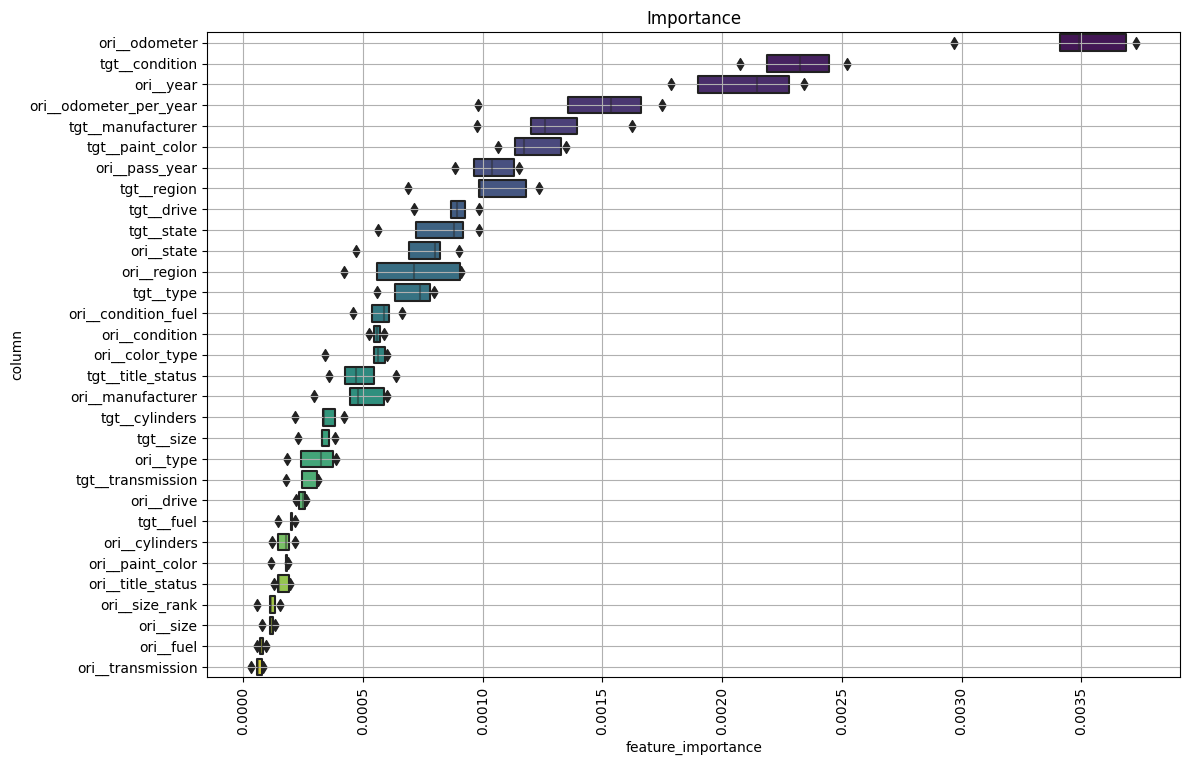

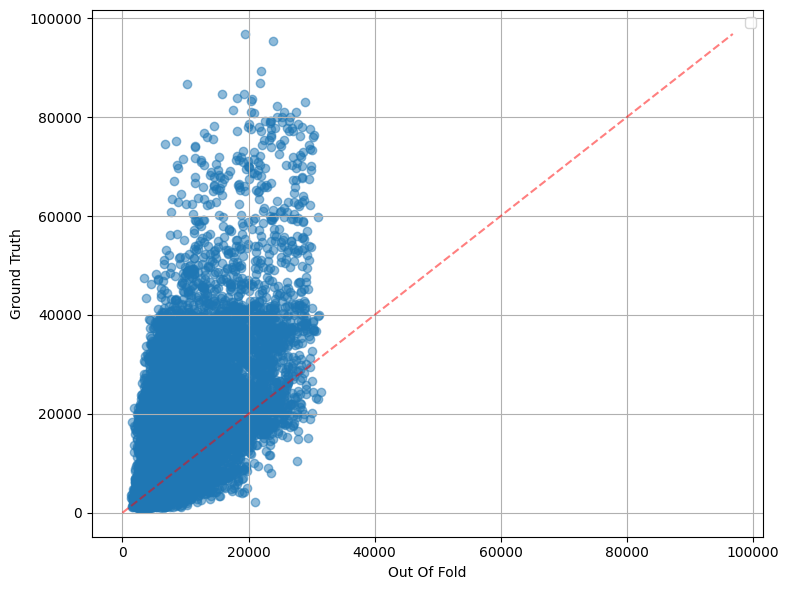

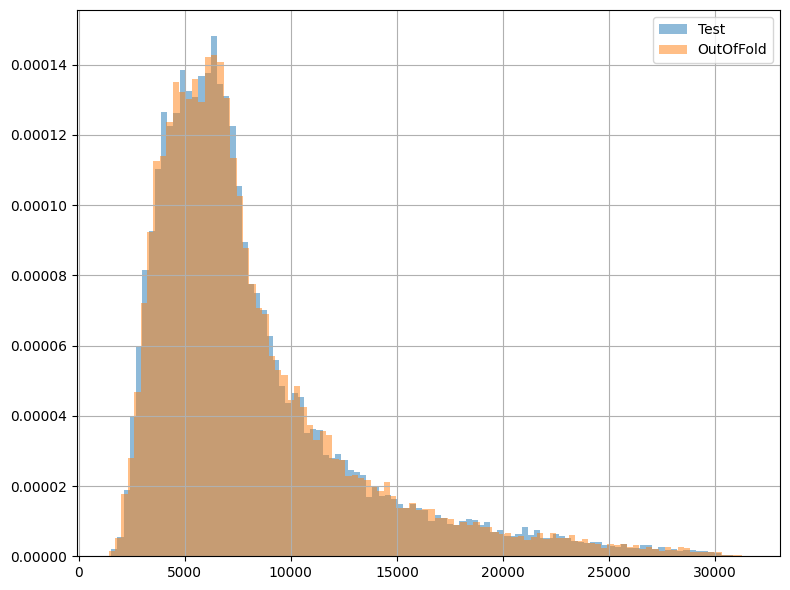

In [10]:
visualize_importance(models, train_feat_df)
visualize_oof_gt(oof, train_df['price'])
visualize_oof_pred(oof, pred)

In [11]:
df.isnull().sum()

id                 0
region             0
year               0
manufacturer       0
condition          0
cylinders          0
fuel            1239
odometer           0
title_status     456
transmission       0
drive              0
size               0
type             456
paint_color        0
state           3304
price              0
dtype: int64

In [12]:
train_df.isnull().sum()

id                      0
region                  0
year                    0
manufacturer            0
condition               0
cylinders              71
fuel                 1239
odometer                0
title_status          456
transmission            0
drive                   0
size                    0
type                  456
paint_color             0
state                3304
price                   0
size_rank               0
odometer_per_year       0
pass_year               0
condition_fuel       1239
color_type            456
dtype: int64

In [13]:
test_df.isnull().sum()

id                      0
region                  0
year                    0
manufacturer            0
condition               0
cylinders              78
fuel                 1495
odometer                0
title_status          229
transmission            0
drive                   0
size                    0
type                  229
paint_color             0
state                3029
size_rank               0
odometer_per_year       0
pass_year               0
condition_fuel       1495
color_type            229
dtype: int64